In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
dataset = pd.read_csv('../../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24
S = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [7]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [8]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [9]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [10]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [11]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/30/20 21:00,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/30/20 22:00,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [12]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96337, 1440)


In [13]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [14]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.57,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.55,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.56,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


#### all target water stages in past $w$ hours

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.60,0.54,1.14,1.18,1.17,1.25,1.62,1.65,1.70,1.67
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,1.17,1.25,1.62,1.65,1.70,1.67,1.93,1.95,2.00,2.00
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.70,1.67,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25


#### merge all data (ws, covariates) in past $w$ hours

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [19]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.56,0.0,0.0,2.57,0.0,0.0,1.62,1.65,1.70,1.67
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,1.93,1.95,2.00,2.00
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.57,0.0,0.0,2.57,0.0,0.0,2.19,2.21,2.25,2.25
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.11,2.12,2.22,2.19


#### shift prior known covariates in future  $S$ steps to the past

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [21]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [22]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [23]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [24]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,1.67,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.00,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.25,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.19,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [25]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [26]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


In [27]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [28]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [29]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [30]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [31]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


### Model

In [38]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 4 cnn with skip connection
x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)


x1_merge1 = concatenate([model_input, x1])
x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge1)


x1_merge2 = concatenate([model_input, x1])
x1 = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge2)


x1_merge3 = concatenate([model_input, x1])
x1 = layers.Conv1D(filters=32, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge3)


merge = concatenate([model_input, x1])
merge = layers.Flatten()(merge)
# x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(merge)

model_cnn = Model(model_input, x)
model_cnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 72, 28)]     0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 72, 256)      14592       input_3[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 72, 284)      0           input_3[0][0]                    
                                                                 conv1d_5[0][0]                   
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 72, 128)      72832       concatenate_4[0][0]        

Epoch 1/8000


2023-01-08 13:27:12.547965: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-08 13:27:12.781268: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-01-08 13:27:14.002476: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-01-08 13:27:14.496263: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.05834, saving model to saved_model/cnn_shift_s24_k24_4layer_sc.h5
151/151 - 60s - loss: 0.0526 - mae: 0.0666 - val_loss: 0.0322 - val_mae: 0.0583
Epoch 2/8000

Epoch 00002: val_mae improved from 0.05834 to 0.04807, saving model to saved_model/cnn_shift_s24_k24_4layer_sc.h5
151/151 - 3s - loss: 0.0222 - mae: 0.0365 - val_loss: 0.0186 - val_mae: 0.0481
Epoch 3/8000

Epoch 00003: val_mae improved from 0.04807 to 0.03878, saving model to saved_model/cnn_shift_s24_k24_4layer_sc.h5
151/151 - 3s - loss: 0.0134 - mae: 0.0274 - val_loss: 0.0121 - val_mae: 0.0388
Epoch 4/8000

Epoch 00004: val_mae improved from 0.03878 to 0.03672, saving model to saved_model/cnn_shift_s24_k24_4layer_sc.h5
151/151 - 3s - loss: 0.0090 - mae: 0.0221 - val_loss: 0.0088 - val_mae: 0.0367
Epoch 5/8000

Epoch 00005: val_mae improved from 0.03672 to 0.03264, saving model to saved_model/cnn_shift_s24_k24_4layer_sc.h5
151/151 - 3s - loss: 0.0064 - mae: 0.0192 - val_loss: 0.0065

Epoch 46/8000

Epoch 00046: val_mae did not improve from 0.01608
151/151 - 3s - loss: 2.6171e-04 - mae: 0.0089 - val_loss: 5.6140e-04 - val_mae: 0.0165
Epoch 47/8000

Epoch 00047: val_mae did not improve from 0.01608
151/151 - 3s - loss: 2.5867e-04 - mae: 0.0088 - val_loss: 7.0553e-04 - val_mae: 0.0187
Epoch 48/8000

Epoch 00048: val_mae did not improve from 0.01608
151/151 - 3s - loss: 2.5845e-04 - mae: 0.0088 - val_loss: 5.8754e-04 - val_mae: 0.0169
Epoch 49/8000

Epoch 00049: val_mae did not improve from 0.01608
151/151 - 3s - loss: 2.5748e-04 - mae: 0.0087 - val_loss: 5.8733e-04 - val_mae: 0.0168
Epoch 50/8000

Epoch 00050: val_mae did not improve from 0.01608
151/151 - 3s - loss: 2.5494e-04 - mae: 0.0087 - val_loss: 6.6060e-04 - val_mae: 0.0181
Epoch 51/8000

Epoch 00051: val_mae did not improve from 0.01608
151/151 - 3s - loss: 2.5650e-04 - mae: 0.0087 - val_loss: 5.5437e-04 - val_mae: 0.0163
Epoch 52/8000

Epoch 00052: val_mae improved from 0.01608 to 0.01557, saving model to sa

Epoch 97/8000

Epoch 00097: val_mae did not improve from 0.01403
151/151 - 3s - loss: 2.2987e-04 - mae: 0.0081 - val_loss: 4.6643e-04 - val_mae: 0.0148
Epoch 98/8000

Epoch 00098: val_mae did not improve from 0.01403
151/151 - 3s - loss: 2.3141e-04 - mae: 0.0081 - val_loss: 5.0982e-04 - val_mae: 0.0156
Epoch 99/8000

Epoch 00099: val_mae improved from 0.01403 to 0.01378, saving model to saved_model/cnn_shift_s24_k24_4layer_sc.h5
151/151 - 3s - loss: 2.2691e-04 - mae: 0.0080 - val_loss: 4.1527e-04 - val_mae: 0.0138
Epoch 100/8000

Epoch 00100: val_mae did not improve from 0.01378
151/151 - 3s - loss: 2.2884e-04 - mae: 0.0080 - val_loss: 4.8691e-04 - val_mae: 0.0149
Epoch 101/8000

Epoch 00101: val_mae did not improve from 0.01378
151/151 - 3s - loss: 2.2906e-04 - mae: 0.0081 - val_loss: 4.6910e-04 - val_mae: 0.0148
Epoch 102/8000

Epoch 00102: val_mae did not improve from 0.01378
151/151 - 3s - loss: 2.2715e-04 - mae: 0.0080 - val_loss: 5.1844e-04 - val_mae: 0.0159
Epoch 103/8000

Epoch

Epoch 150/8000

Epoch 00150: val_mae did not improve from 0.01297
151/151 - 3s - loss: 2.1372e-04 - mae: 0.0076 - val_loss: 4.0403e-04 - val_mae: 0.0137
Epoch 151/8000

Epoch 00151: val_mae did not improve from 0.01297
151/151 - 3s - loss: 2.1617e-04 - mae: 0.0077 - val_loss: 5.1954e-04 - val_mae: 0.0155
Epoch 152/8000

Epoch 00152: val_mae did not improve from 0.01297
151/151 - 3s - loss: 2.1439e-04 - mae: 0.0076 - val_loss: 3.7454e-04 - val_mae: 0.0130
Epoch 153/8000

Epoch 00153: val_mae did not improve from 0.01297
151/151 - 3s - loss: 2.1586e-04 - mae: 0.0077 - val_loss: 4.3376e-04 - val_mae: 0.0145
Epoch 154/8000

Epoch 00154: val_mae did not improve from 0.01297
151/151 - 3s - loss: 2.1574e-04 - mae: 0.0077 - val_loss: 4.0632e-04 - val_mae: 0.0137
Epoch 155/8000

Epoch 00155: val_mae did not improve from 0.01297
151/151 - 3s - loss: 2.1605e-04 - mae: 0.0077 - val_loss: 4.7754e-04 - val_mae: 0.0149
Epoch 156/8000

Epoch 00156: val_mae did not improve from 0.01297
151/151 - 3s - l

Epoch 204/8000

Epoch 00204: val_mae did not improve from 0.01278
151/151 - 3s - loss: 2.0720e-04 - mae: 0.0075 - val_loss: 4.2529e-04 - val_mae: 0.0141
Epoch 205/8000

Epoch 00205: val_mae did not improve from 0.01278
151/151 - 3s - loss: 2.0835e-04 - mae: 0.0076 - val_loss: 3.9309e-04 - val_mae: 0.0136
Epoch 206/8000

Epoch 00206: val_mae did not improve from 0.01278
151/151 - 3s - loss: 2.1091e-04 - mae: 0.0076 - val_loss: 3.7198e-04 - val_mae: 0.0131
Epoch 207/8000

Epoch 00207: val_mae improved from 0.01278 to 0.01213, saving model to saved_model/cnn_shift_s24_k24_4layer_sc.h5
151/151 - 3s - loss: 2.0755e-04 - mae: 0.0075 - val_loss: 3.3134e-04 - val_mae: 0.0121
Epoch 208/8000

Epoch 00208: val_mae did not improve from 0.01213
151/151 - 3s - loss: 2.0697e-04 - mae: 0.0075 - val_loss: 4.2333e-04 - val_mae: 0.0141
Epoch 209/8000

Epoch 00209: val_mae did not improve from 0.01213
151/151 - 3s - loss: 2.0692e-04 - mae: 0.0075 - val_loss: 4.2596e-04 - val_mae: 0.0141
Epoch 210/8000

Ep

Epoch 258/8000

Epoch 00258: val_mae did not improve from 0.01213
151/151 - 3s - loss: 2.0326e-04 - mae: 0.0074 - val_loss: 4.1221e-04 - val_mae: 0.0138
Epoch 259/8000

Epoch 00259: val_mae did not improve from 0.01213
151/151 - 3s - loss: 2.0340e-04 - mae: 0.0074 - val_loss: 3.6097e-04 - val_mae: 0.0128
Epoch 260/8000

Epoch 00260: val_mae did not improve from 0.01213
151/151 - 3s - loss: 2.0666e-04 - mae: 0.0076 - val_loss: 4.3969e-04 - val_mae: 0.0142
Epoch 261/8000

Epoch 00261: val_mae did not improve from 0.01213
151/151 - 3s - loss: 1.9937e-04 - mae: 0.0073 - val_loss: 4.3929e-04 - val_mae: 0.0146
Epoch 262/8000

Epoch 00262: val_mae did not improve from 0.01213
151/151 - 3s - loss: 2.0129e-04 - mae: 0.0074 - val_loss: 4.1259e-04 - val_mae: 0.0138
Epoch 263/8000

Epoch 00263: val_mae did not improve from 0.01213
151/151 - 3s - loss: 2.0212e-04 - mae: 0.0074 - val_loss: 3.8245e-04 - val_mae: 0.0133
Epoch 264/8000

Epoch 00264: val_mae did not improve from 0.01213
151/151 - 3s - l

Epoch 312/8000

Epoch 00312: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9704e-04 - mae: 0.0073 - val_loss: 4.0386e-04 - val_mae: 0.0135
Epoch 313/8000

Epoch 00313: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9742e-04 - mae: 0.0073 - val_loss: 5.1866e-04 - val_mae: 0.0158
Epoch 314/8000

Epoch 00314: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9839e-04 - mae: 0.0073 - val_loss: 4.2273e-04 - val_mae: 0.0139
Epoch 315/8000

Epoch 00315: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9731e-04 - mae: 0.0073 - val_loss: 4.4734e-04 - val_mae: 0.0150
Epoch 316/8000

Epoch 00316: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9973e-04 - mae: 0.0074 - val_loss: 5.0109e-04 - val_mae: 0.0150
Epoch 317/8000

Epoch 00317: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9876e-04 - mae: 0.0073 - val_loss: 3.6427e-04 - val_mae: 0.0128
Epoch 318/8000

Epoch 00318: val_mae did not improve from 0.01146
151/151 - 3s - l

Epoch 366/8000

Epoch 00366: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9559e-04 - mae: 0.0073 - val_loss: 4.3158e-04 - val_mae: 0.0141
Epoch 367/8000

Epoch 00367: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9685e-04 - mae: 0.0073 - val_loss: 4.2593e-04 - val_mae: 0.0139
Epoch 368/8000

Epoch 00368: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9265e-04 - mae: 0.0071 - val_loss: 3.7154e-04 - val_mae: 0.0129
Epoch 369/8000

Epoch 00369: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9478e-04 - mae: 0.0072 - val_loss: 3.6333e-04 - val_mae: 0.0126
Epoch 370/8000

Epoch 00370: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9724e-04 - mae: 0.0073 - val_loss: 4.3483e-04 - val_mae: 0.0140
Epoch 371/8000

Epoch 00371: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9378e-04 - mae: 0.0072 - val_loss: 3.7917e-04 - val_mae: 0.0133
Epoch 372/8000

Epoch 00372: val_mae did not improve from 0.01146
151/151 - 3s - l

Epoch 420/8000

Epoch 00420: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9353e-04 - mae: 0.0072 - val_loss: 4.3264e-04 - val_mae: 0.0141
Epoch 421/8000

Epoch 00421: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9308e-04 - mae: 0.0072 - val_loss: 4.0853e-04 - val_mae: 0.0135
Epoch 422/8000

Epoch 00422: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.8977e-04 - mae: 0.0071 - val_loss: 3.5688e-04 - val_mae: 0.0127
Epoch 423/8000

Epoch 00423: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.8921e-04 - mae: 0.0070 - val_loss: 3.8631e-04 - val_mae: 0.0132
Epoch 424/8000

Epoch 00424: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9320e-04 - mae: 0.0072 - val_loss: 3.8659e-04 - val_mae: 0.0132
Epoch 425/8000

Epoch 00425: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9027e-04 - mae: 0.0071 - val_loss: 3.8736e-04 - val_mae: 0.0132
Epoch 426/8000

Epoch 00426: val_mae did not improve from 0.01146
151/151 - 3s - l

Epoch 474/8000

Epoch 00474: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.8820e-04 - mae: 0.0070 - val_loss: 4.3516e-04 - val_mae: 0.0142
Epoch 475/8000

Epoch 00475: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9014e-04 - mae: 0.0071 - val_loss: 3.6164e-04 - val_mae: 0.0129
Epoch 476/8000

Epoch 00476: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.8756e-04 - mae: 0.0070 - val_loss: 3.8112e-04 - val_mae: 0.0131
Epoch 477/8000

Epoch 00477: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.9323e-04 - mae: 0.0073 - val_loss: 3.2994e-04 - val_mae: 0.0120
Epoch 478/8000

Epoch 00478: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.8998e-04 - mae: 0.0071 - val_loss: 4.0058e-04 - val_mae: 0.0137
Epoch 479/8000

Epoch 00479: val_mae did not improve from 0.01146
151/151 - 3s - loss: 1.8677e-04 - mae: 0.0070 - val_loss: 3.5816e-04 - val_mae: 0.0127
Epoch 480/8000

Epoch 00480: val_mae did not improve from 0.01146
151/151 - 3s - l

Epoch 528/8000

Epoch 00528: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8585e-04 - mae: 0.0070 - val_loss: 4.3151e-04 - val_mae: 0.0140
Epoch 529/8000

Epoch 00529: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8530e-04 - mae: 0.0070 - val_loss: 3.6266e-04 - val_mae: 0.0128
Epoch 530/8000

Epoch 00530: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8640e-04 - mae: 0.0070 - val_loss: 4.1103e-04 - val_mae: 0.0139
Epoch 531/8000

Epoch 00531: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8653e-04 - mae: 0.0070 - val_loss: 3.9128e-04 - val_mae: 0.0134
Epoch 532/8000

Epoch 00532: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8694e-04 - mae: 0.0070 - val_loss: 3.3783e-04 - val_mae: 0.0123
Epoch 533/8000

Epoch 00533: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8774e-04 - mae: 0.0071 - val_loss: 4.3076e-04 - val_mae: 0.0141
Epoch 534/8000

Epoch 00534: val_mae did not improve from 0.01134
151/151 - 3s - l

Epoch 582/8000

Epoch 00582: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8648e-04 - mae: 0.0070 - val_loss: 3.7457e-04 - val_mae: 0.0131
Epoch 583/8000

Epoch 00583: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8442e-04 - mae: 0.0070 - val_loss: 4.1390e-04 - val_mae: 0.0139
Epoch 584/8000

Epoch 00584: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8659e-04 - mae: 0.0071 - val_loss: 3.7283e-04 - val_mae: 0.0131
Epoch 585/8000

Epoch 00585: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8482e-04 - mae: 0.0070 - val_loss: 3.4898e-04 - val_mae: 0.0125
Epoch 586/8000

Epoch 00586: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8476e-04 - mae: 0.0070 - val_loss: 3.9368e-04 - val_mae: 0.0136
Epoch 587/8000

Epoch 00587: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8687e-04 - mae: 0.0071 - val_loss: 3.8716e-04 - val_mae: 0.0135
Epoch 588/8000

Epoch 00588: val_mae did not improve from 0.01134
151/151 - 3s - l

Epoch 636/8000

Epoch 00636: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8257e-04 - mae: 0.0069 - val_loss: 3.9047e-04 - val_mae: 0.0134
Epoch 637/8000

Epoch 00637: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8397e-04 - mae: 0.0070 - val_loss: 3.9117e-04 - val_mae: 0.0134
Epoch 638/8000

Epoch 00638: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8153e-04 - mae: 0.0068 - val_loss: 4.0398e-04 - val_mae: 0.0134
Epoch 639/8000

Epoch 00639: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8236e-04 - mae: 0.0069 - val_loss: 3.7934e-04 - val_mae: 0.0132
Epoch 640/8000

Epoch 00640: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8183e-04 - mae: 0.0069 - val_loss: 3.4686e-04 - val_mae: 0.0123
Epoch 641/8000

Epoch 00641: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8170e-04 - mae: 0.0069 - val_loss: 3.9325e-04 - val_mae: 0.0133
Epoch 642/8000

Epoch 00642: val_mae did not improve from 0.01134
151/151 - 3s - l

Epoch 690/8000

Epoch 00690: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8210e-04 - mae: 0.0069 - val_loss: 3.7148e-04 - val_mae: 0.0128
Epoch 691/8000

Epoch 00691: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8049e-04 - mae: 0.0068 - val_loss: 3.6115e-04 - val_mae: 0.0124
Epoch 692/8000

Epoch 00692: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8054e-04 - mae: 0.0068 - val_loss: 3.6789e-04 - val_mae: 0.0126
Epoch 693/8000

Epoch 00693: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.7913e-04 - mae: 0.0068 - val_loss: 3.9288e-04 - val_mae: 0.0134
Epoch 694/8000

Epoch 00694: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8373e-04 - mae: 0.0070 - val_loss: 3.4430e-04 - val_mae: 0.0121
Epoch 695/8000

Epoch 00695: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.7858e-04 - mae: 0.0067 - val_loss: 3.7399e-04 - val_mae: 0.0128
Epoch 696/8000

Epoch 00696: val_mae did not improve from 0.01134
151/151 - 3s - l

Epoch 744/8000

Epoch 00744: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8073e-04 - mae: 0.0069 - val_loss: 3.5491e-04 - val_mae: 0.0124
Epoch 745/8000

Epoch 00745: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.7669e-04 - mae: 0.0067 - val_loss: 3.2457e-04 - val_mae: 0.0119
Epoch 746/8000

Epoch 00746: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8014e-04 - mae: 0.0068 - val_loss: 3.1048e-04 - val_mae: 0.0116
Epoch 747/8000

Epoch 00747: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.8034e-04 - mae: 0.0069 - val_loss: 2.9850e-04 - val_mae: 0.0115
Epoch 748/8000

Epoch 00748: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.7861e-04 - mae: 0.0068 - val_loss: 3.6478e-04 - val_mae: 0.0128
Epoch 749/8000

Epoch 00749: val_mae did not improve from 0.01134
151/151 - 3s - loss: 1.7567e-04 - mae: 0.0066 - val_loss: 3.5285e-04 - val_mae: 0.0125
Epoch 750/8000

Epoch 00750: val_mae did not improve from 0.01134
151/151 - 3s - l

Epoch 797/8000

Epoch 00797: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7599e-04 - mae: 0.0067 - val_loss: 3.9435e-04 - val_mae: 0.0134
Epoch 798/8000

Epoch 00798: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7616e-04 - mae: 0.0067 - val_loss: 3.4513e-04 - val_mae: 0.0122
Epoch 799/8000

Epoch 00799: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7602e-04 - mae: 0.0067 - val_loss: 3.7896e-04 - val_mae: 0.0128
Epoch 800/8000

Epoch 00800: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7899e-04 - mae: 0.0068 - val_loss: 3.8037e-04 - val_mae: 0.0129
Epoch 801/8000

Epoch 00801: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7707e-04 - mae: 0.0067 - val_loss: 4.5213e-04 - val_mae: 0.0139
Epoch 802/8000

Epoch 00802: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7552e-04 - mae: 0.0067 - val_loss: 3.2965e-04 - val_mae: 0.0119
Epoch 803/8000

Epoch 00803: val_mae did not improve from 0.01088
151/151 - 3s - l

Epoch 851/8000

Epoch 00851: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7546e-04 - mae: 0.0067 - val_loss: 3.6697e-04 - val_mae: 0.0128
Epoch 852/8000

Epoch 00852: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7597e-04 - mae: 0.0067 - val_loss: 4.1366e-04 - val_mae: 0.0135
Epoch 853/8000

Epoch 00853: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7626e-04 - mae: 0.0067 - val_loss: 3.7999e-04 - val_mae: 0.0129
Epoch 854/8000

Epoch 00854: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7515e-04 - mae: 0.0067 - val_loss: 4.0805e-04 - val_mae: 0.0134
Epoch 855/8000

Epoch 00855: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7512e-04 - mae: 0.0067 - val_loss: 4.3250e-04 - val_mae: 0.0136
Epoch 856/8000

Epoch 00856: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7412e-04 - mae: 0.0066 - val_loss: 4.2645e-04 - val_mae: 0.0135
Epoch 857/8000

Epoch 00857: val_mae did not improve from 0.01088
151/151 - 3s - l

Epoch 905/8000

Epoch 00905: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7462e-04 - mae: 0.0067 - val_loss: 3.3840e-04 - val_mae: 0.0120
Epoch 906/8000

Epoch 00906: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7437e-04 - mae: 0.0067 - val_loss: 3.4796e-04 - val_mae: 0.0122
Epoch 907/8000

Epoch 00907: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7410e-04 - mae: 0.0066 - val_loss: 3.4031e-04 - val_mae: 0.0120
Epoch 908/8000

Epoch 00908: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7380e-04 - mae: 0.0066 - val_loss: 3.5505e-04 - val_mae: 0.0128
Epoch 909/8000

Epoch 00909: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7372e-04 - mae: 0.0066 - val_loss: 3.6065e-04 - val_mae: 0.0127
Epoch 910/8000

Epoch 00910: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7303e-04 - mae: 0.0066 - val_loss: 3.7092e-04 - val_mae: 0.0129
Epoch 911/8000

Epoch 00911: val_mae did not improve from 0.01088
151/151 - 3s - l

Epoch 959/8000

Epoch 00959: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7129e-04 - mae: 0.0065 - val_loss: 3.9377e-04 - val_mae: 0.0132
Epoch 960/8000

Epoch 00960: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7249e-04 - mae: 0.0066 - val_loss: 4.3547e-04 - val_mae: 0.0137
Epoch 961/8000

Epoch 00961: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7393e-04 - mae: 0.0067 - val_loss: 3.8081e-04 - val_mae: 0.0127
Epoch 962/8000

Epoch 00962: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7089e-04 - mae: 0.0065 - val_loss: 3.7392e-04 - val_mae: 0.0129
Epoch 963/8000

Epoch 00963: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7349e-04 - mae: 0.0066 - val_loss: 3.9194e-04 - val_mae: 0.0133
Epoch 964/8000

Epoch 00964: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7177e-04 - mae: 0.0066 - val_loss: 3.9374e-04 - val_mae: 0.0128
Epoch 965/8000

Epoch 00965: val_mae did not improve from 0.01088
151/151 - 3s - l

Epoch 1013/8000

Epoch 01013: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7097e-04 - mae: 0.0065 - val_loss: 4.5304e-04 - val_mae: 0.0142
Epoch 1014/8000

Epoch 01014: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7176e-04 - mae: 0.0066 - val_loss: 4.0447e-04 - val_mae: 0.0135
Epoch 1015/8000

Epoch 01015: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7173e-04 - mae: 0.0066 - val_loss: 3.4449e-04 - val_mae: 0.0122
Epoch 1016/8000

Epoch 01016: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7122e-04 - mae: 0.0065 - val_loss: 3.7527e-04 - val_mae: 0.0129
Epoch 1017/8000

Epoch 01017: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7047e-04 - mae: 0.0065 - val_loss: 2.9382e-04 - val_mae: 0.0111
Epoch 1018/8000

Epoch 01018: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7279e-04 - mae: 0.0066 - val_loss: 3.1240e-04 - val_mae: 0.0116
Epoch 1019/8000

Epoch 01019: val_mae did not improve from 0.01088
151/151 -

Epoch 1067/8000

Epoch 01067: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.6861e-04 - mae: 0.0065 - val_loss: 3.9247e-04 - val_mae: 0.0134
Epoch 1068/8000

Epoch 01068: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.6946e-04 - mae: 0.0065 - val_loss: 3.2920e-04 - val_mae: 0.0118
Epoch 1069/8000

Epoch 01069: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7208e-04 - mae: 0.0066 - val_loss: 3.5772e-04 - val_mae: 0.0124
Epoch 1070/8000

Epoch 01070: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.6919e-04 - mae: 0.0065 - val_loss: 3.2939e-04 - val_mae: 0.0121
Epoch 1071/8000

Epoch 01071: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7168e-04 - mae: 0.0066 - val_loss: 4.4094e-04 - val_mae: 0.0136
Epoch 1072/8000

Epoch 01072: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.6966e-04 - mae: 0.0065 - val_loss: 3.4267e-04 - val_mae: 0.0122
Epoch 1073/8000

Epoch 01073: val_mae did not improve from 0.01088
151/151 -

Epoch 1121/8000

Epoch 01121: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7004e-04 - mae: 0.0066 - val_loss: 3.3332e-04 - val_mae: 0.0118
Epoch 1122/8000

Epoch 01122: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.6893e-04 - mae: 0.0065 - val_loss: 3.5084e-04 - val_mae: 0.0123
Epoch 1123/8000

Epoch 01123: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.7088e-04 - mae: 0.0066 - val_loss: 3.9872e-04 - val_mae: 0.0134
Epoch 1124/8000

Epoch 01124: val_mae did not improve from 0.01088
151/151 - 3s - loss: 1.6813e-04 - mae: 0.0064 - val_loss: 3.0581e-04 - val_mae: 0.0113
Epoch 1125/8000

Epoch 01125: val_mae improved from 0.01088 to 0.01058, saving model to saved_model/cnn_shift_s24_k24_4layer_sc.h5
151/151 - 3s - loss: 1.7046e-04 - mae: 0.0066 - val_loss: 2.7698e-04 - val_mae: 0.0106
Epoch 1126/8000

Epoch 01126: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6884e-04 - mae: 0.0065 - val_loss: 4.2179e-04 - val_mae: 0.0136
Epoch 1127/8

Epoch 1174/8000

Epoch 01174: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6786e-04 - mae: 0.0065 - val_loss: 3.1545e-04 - val_mae: 0.0117
Epoch 1175/8000

Epoch 01175: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6771e-04 - mae: 0.0065 - val_loss: 3.5498e-04 - val_mae: 0.0124
Epoch 1176/8000

Epoch 01176: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6799e-04 - mae: 0.0065 - val_loss: 3.6357e-04 - val_mae: 0.0127
Epoch 1177/8000

Epoch 01177: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6932e-04 - mae: 0.0065 - val_loss: 3.7595e-04 - val_mae: 0.0129
Epoch 1178/8000

Epoch 01178: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6639e-04 - mae: 0.0064 - val_loss: 3.5940e-04 - val_mae: 0.0128
Epoch 1179/8000

Epoch 01179: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6675e-04 - mae: 0.0064 - val_loss: 3.0718e-04 - val_mae: 0.0115
Epoch 1180/8000

Epoch 01180: val_mae did not improve from 0.01058
151/151 -

Epoch 1228/8000

Epoch 01228: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.7177e-04 - mae: 0.0067 - val_loss: 5.0925e-04 - val_mae: 0.0149
Epoch 1229/8000

Epoch 01229: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6776e-04 - mae: 0.0065 - val_loss: 4.4300e-04 - val_mae: 0.0140
Epoch 1230/8000

Epoch 01230: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6634e-04 - mae: 0.0064 - val_loss: 3.3312e-04 - val_mae: 0.0120
Epoch 1231/8000

Epoch 01231: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6742e-04 - mae: 0.0065 - val_loss: 3.8778e-04 - val_mae: 0.0131
Epoch 1232/8000

Epoch 01232: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6696e-04 - mae: 0.0064 - val_loss: 3.2484e-04 - val_mae: 0.0117
Epoch 1233/8000

Epoch 01233: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6736e-04 - mae: 0.0065 - val_loss: 4.0441e-04 - val_mae: 0.0135
Epoch 1234/8000

Epoch 01234: val_mae did not improve from 0.01058
151/151 -

Epoch 1282/8000

Epoch 01282: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6461e-04 - mae: 0.0064 - val_loss: 3.4082e-04 - val_mae: 0.0121
Epoch 1283/8000

Epoch 01283: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6638e-04 - mae: 0.0064 - val_loss: 3.9271e-04 - val_mae: 0.0132
Epoch 1284/8000

Epoch 01284: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6949e-04 - mae: 0.0066 - val_loss: 4.2252e-04 - val_mae: 0.0138
Epoch 1285/8000

Epoch 01285: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6757e-04 - mae: 0.0065 - val_loss: 3.6916e-04 - val_mae: 0.0123
Epoch 1286/8000

Epoch 01286: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6553e-04 - mae: 0.0064 - val_loss: 3.4826e-04 - val_mae: 0.0124
Epoch 1287/8000

Epoch 01287: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6613e-04 - mae: 0.0064 - val_loss: 3.6648e-04 - val_mae: 0.0125
Epoch 1288/8000

Epoch 01288: val_mae did not improve from 0.01058
151/151 -

Epoch 1336/8000

Epoch 01336: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6653e-04 - mae: 0.0065 - val_loss: 3.9751e-04 - val_mae: 0.0132
Epoch 1337/8000

Epoch 01337: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6543e-04 - mae: 0.0064 - val_loss: 3.7281e-04 - val_mae: 0.0127
Epoch 1338/8000

Epoch 01338: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6467e-04 - mae: 0.0064 - val_loss: 4.7837e-04 - val_mae: 0.0143
Epoch 1339/8000

Epoch 01339: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6486e-04 - mae: 0.0064 - val_loss: 3.5370e-04 - val_mae: 0.0123
Epoch 1340/8000

Epoch 01340: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6552e-04 - mae: 0.0064 - val_loss: 3.0674e-04 - val_mae: 0.0115
Epoch 1341/8000

Epoch 01341: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6350e-04 - mae: 0.0063 - val_loss: 3.4798e-04 - val_mae: 0.0123
Epoch 1342/8000

Epoch 01342: val_mae did not improve from 0.01058
151/151 -

Epoch 1390/8000

Epoch 01390: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6603e-04 - mae: 0.0065 - val_loss: 4.1803e-04 - val_mae: 0.0133
Epoch 1391/8000

Epoch 01391: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6302e-04 - mae: 0.0063 - val_loss: 3.3363e-04 - val_mae: 0.0120
Epoch 1392/8000

Epoch 01392: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6559e-04 - mae: 0.0064 - val_loss: 3.4054e-04 - val_mae: 0.0120
Epoch 1393/8000

Epoch 01393: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6739e-04 - mae: 0.0065 - val_loss: 3.3393e-04 - val_mae: 0.0120
Epoch 1394/8000

Epoch 01394: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6280e-04 - mae: 0.0063 - val_loss: 3.4583e-04 - val_mae: 0.0122
Epoch 1395/8000

Epoch 01395: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6347e-04 - mae: 0.0063 - val_loss: 3.9910e-04 - val_mae: 0.0133
Epoch 1396/8000

Epoch 01396: val_mae did not improve from 0.01058
151/151 -

Epoch 1444/8000

Epoch 01444: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6290e-04 - mae: 0.0063 - val_loss: 3.4883e-04 - val_mae: 0.0125
Epoch 1445/8000

Epoch 01445: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6252e-04 - mae: 0.0063 - val_loss: 4.3834e-04 - val_mae: 0.0143
Epoch 1446/8000

Epoch 01446: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6368e-04 - mae: 0.0064 - val_loss: 3.1253e-04 - val_mae: 0.0117
Epoch 1447/8000

Epoch 01447: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6358e-04 - mae: 0.0064 - val_loss: 3.3760e-04 - val_mae: 0.0122
Epoch 1448/8000

Epoch 01448: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6313e-04 - mae: 0.0064 - val_loss: 3.8819e-04 - val_mae: 0.0129
Epoch 1449/8000

Epoch 01449: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6408e-04 - mae: 0.0064 - val_loss: 3.0748e-04 - val_mae: 0.0115
Epoch 1450/8000

Epoch 01450: val_mae did not improve from 0.01058
151/151 -

Epoch 1498/8000

Epoch 01498: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6352e-04 - mae: 0.0064 - val_loss: 3.8114e-04 - val_mae: 0.0128
Epoch 1499/8000

Epoch 01499: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6212e-04 - mae: 0.0063 - val_loss: 3.4503e-04 - val_mae: 0.0122
Epoch 1500/8000

Epoch 01500: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6125e-04 - mae: 0.0063 - val_loss: 3.3679e-04 - val_mae: 0.0120
Epoch 1501/8000

Epoch 01501: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6146e-04 - mae: 0.0063 - val_loss: 3.2226e-04 - val_mae: 0.0120
Epoch 1502/8000

Epoch 01502: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6286e-04 - mae: 0.0063 - val_loss: 3.4281e-04 - val_mae: 0.0121
Epoch 1503/8000

Epoch 01503: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6306e-04 - mae: 0.0064 - val_loss: 3.2505e-04 - val_mae: 0.0120
Epoch 1504/8000

Epoch 01504: val_mae did not improve from 0.01058
151/151 -

Epoch 1552/8000

Epoch 01552: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6101e-04 - mae: 0.0063 - val_loss: 3.2022e-04 - val_mae: 0.0117
Epoch 1553/8000

Epoch 01553: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6312e-04 - mae: 0.0064 - val_loss: 3.1933e-04 - val_mae: 0.0117
Epoch 1554/8000

Epoch 01554: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6153e-04 - mae: 0.0063 - val_loss: 3.3981e-04 - val_mae: 0.0122
Epoch 1555/8000

Epoch 01555: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6223e-04 - mae: 0.0063 - val_loss: 3.5889e-04 - val_mae: 0.0125
Epoch 1556/8000

Epoch 01556: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6129e-04 - mae: 0.0063 - val_loss: 3.2754e-04 - val_mae: 0.0120
Epoch 1557/8000

Epoch 01557: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6204e-04 - mae: 0.0063 - val_loss: 3.2102e-04 - val_mae: 0.0119
Epoch 1558/8000

Epoch 01558: val_mae did not improve from 0.01058
151/151 -

Epoch 1606/8000

Epoch 01606: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6274e-04 - mae: 0.0064 - val_loss: 3.0593e-04 - val_mae: 0.0116
Epoch 1607/8000

Epoch 01607: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6103e-04 - mae: 0.0063 - val_loss: 3.7957e-04 - val_mae: 0.0132
Epoch 1608/8000

Epoch 01608: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5915e-04 - mae: 0.0062 - val_loss: 4.0401e-04 - val_mae: 0.0134
Epoch 1609/8000

Epoch 01609: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6148e-04 - mae: 0.0064 - val_loss: 3.7728e-04 - val_mae: 0.0132
Epoch 1610/8000

Epoch 01610: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6007e-04 - mae: 0.0063 - val_loss: 3.8728e-04 - val_mae: 0.0132
Epoch 1611/8000

Epoch 01611: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6182e-04 - mae: 0.0064 - val_loss: 3.8146e-04 - val_mae: 0.0126
Epoch 1612/8000

Epoch 01612: val_mae did not improve from 0.01058
151/151 -

Epoch 1660/8000

Epoch 01660: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6174e-04 - mae: 0.0064 - val_loss: 3.6114e-04 - val_mae: 0.0126
Epoch 1661/8000

Epoch 01661: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6104e-04 - mae: 0.0063 - val_loss: 3.2148e-04 - val_mae: 0.0118
Epoch 1662/8000

Epoch 01662: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5866e-04 - mae: 0.0062 - val_loss: 3.5175e-04 - val_mae: 0.0124
Epoch 1663/8000

Epoch 01663: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6039e-04 - mae: 0.0063 - val_loss: 2.7537e-04 - val_mae: 0.0106
Epoch 1664/8000

Epoch 01664: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5918e-04 - mae: 0.0062 - val_loss: 3.5937e-04 - val_mae: 0.0125
Epoch 1665/8000

Epoch 01665: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6048e-04 - mae: 0.0063 - val_loss: 3.7488e-04 - val_mae: 0.0126
Epoch 1666/8000

Epoch 01666: val_mae did not improve from 0.01058
151/151 -

Epoch 1714/8000

Epoch 01714: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5994e-04 - mae: 0.0063 - val_loss: 2.8770e-04 - val_mae: 0.0110
Epoch 1715/8000

Epoch 01715: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5897e-04 - mae: 0.0062 - val_loss: 3.3048e-04 - val_mae: 0.0120
Epoch 1716/8000

Epoch 01716: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5897e-04 - mae: 0.0063 - val_loss: 3.7140e-04 - val_mae: 0.0127
Epoch 1717/8000

Epoch 01717: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5904e-04 - mae: 0.0063 - val_loss: 3.3025e-04 - val_mae: 0.0118
Epoch 1718/8000

Epoch 01718: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5980e-04 - mae: 0.0063 - val_loss: 3.4609e-04 - val_mae: 0.0123
Epoch 1719/8000

Epoch 01719: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5833e-04 - mae: 0.0062 - val_loss: 3.4772e-04 - val_mae: 0.0124
Epoch 1720/8000

Epoch 01720: val_mae did not improve from 0.01058
151/151 -

Epoch 1768/8000

Epoch 01768: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5841e-04 - mae: 0.0062 - val_loss: 3.2340e-04 - val_mae: 0.0117
Epoch 1769/8000

Epoch 01769: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5918e-04 - mae: 0.0063 - val_loss: 3.3039e-04 - val_mae: 0.0122
Epoch 1770/8000

Epoch 01770: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5761e-04 - mae: 0.0062 - val_loss: 3.3809e-04 - val_mae: 0.0122
Epoch 1771/8000

Epoch 01771: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5706e-04 - mae: 0.0062 - val_loss: 3.5092e-04 - val_mae: 0.0123
Epoch 1772/8000

Epoch 01772: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5941e-04 - mae: 0.0063 - val_loss: 3.4911e-04 - val_mae: 0.0123
Epoch 1773/8000

Epoch 01773: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.6025e-04 - mae: 0.0063 - val_loss: 3.2919e-04 - val_mae: 0.0119
Epoch 1774/8000

Epoch 01774: val_mae did not improve from 0.01058
151/151 -

Epoch 1822/8000

Epoch 01822: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5769e-04 - mae: 0.0062 - val_loss: 3.9605e-04 - val_mae: 0.0135
Epoch 1823/8000

Epoch 01823: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5668e-04 - mae: 0.0062 - val_loss: 3.6956e-04 - val_mae: 0.0131
Epoch 1824/8000

Epoch 01824: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5670e-04 - mae: 0.0062 - val_loss: 3.6803e-04 - val_mae: 0.0126
Epoch 1825/8000

Epoch 01825: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5677e-04 - mae: 0.0062 - val_loss: 3.3578e-04 - val_mae: 0.0118
Epoch 1826/8000

Epoch 01826: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5821e-04 - mae: 0.0063 - val_loss: 3.7959e-04 - val_mae: 0.0130
Epoch 1827/8000

Epoch 01827: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5927e-04 - mae: 0.0063 - val_loss: 3.0128e-04 - val_mae: 0.0114
Epoch 1828/8000

Epoch 01828: val_mae did not improve from 0.01058
151/151 -

Epoch 1876/8000

Epoch 01876: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5659e-04 - mae: 0.0062 - val_loss: 3.4102e-04 - val_mae: 0.0121
Epoch 1877/8000

Epoch 01877: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5928e-04 - mae: 0.0063 - val_loss: 2.9787e-04 - val_mae: 0.0113
Epoch 1878/8000

Epoch 01878: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5614e-04 - mae: 0.0062 - val_loss: 4.3096e-04 - val_mae: 0.0138
Epoch 1879/8000

Epoch 01879: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5733e-04 - mae: 0.0062 - val_loss: 3.3817e-04 - val_mae: 0.0119
Epoch 1880/8000

Epoch 01880: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5699e-04 - mae: 0.0062 - val_loss: 3.3643e-04 - val_mae: 0.0121
Epoch 1881/8000

Epoch 01881: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5574e-04 - mae: 0.0062 - val_loss: 2.9356e-04 - val_mae: 0.0114
Epoch 1882/8000

Epoch 01882: val_mae did not improve from 0.01058
151/151 -

Epoch 1930/8000

Epoch 01930: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5799e-04 - mae: 0.0063 - val_loss: 3.2920e-04 - val_mae: 0.0121
Epoch 1931/8000

Epoch 01931: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5834e-04 - mae: 0.0063 - val_loss: 3.4769e-04 - val_mae: 0.0124
Epoch 1932/8000

Epoch 01932: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5463e-04 - mae: 0.0061 - val_loss: 3.3156e-04 - val_mae: 0.0121
Epoch 1933/8000

Epoch 01933: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5668e-04 - mae: 0.0062 - val_loss: 3.1301e-04 - val_mae: 0.0116
Epoch 1934/8000

Epoch 01934: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5584e-04 - mae: 0.0062 - val_loss: 3.9728e-04 - val_mae: 0.0131
Epoch 1935/8000

Epoch 01935: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5589e-04 - mae: 0.0062 - val_loss: 3.2601e-04 - val_mae: 0.0120
Epoch 1936/8000

Epoch 01936: val_mae did not improve from 0.01058
151/151 -

Epoch 1984/8000

Epoch 01984: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5473e-04 - mae: 0.0061 - val_loss: 3.9052e-04 - val_mae: 0.0128
Epoch 1985/8000

Epoch 01985: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5547e-04 - mae: 0.0062 - val_loss: 3.9234e-04 - val_mae: 0.0131
Epoch 1986/8000

Epoch 01986: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5575e-04 - mae: 0.0062 - val_loss: 3.1283e-04 - val_mae: 0.0115
Epoch 1987/8000

Epoch 01987: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5714e-04 - mae: 0.0063 - val_loss: 3.5822e-04 - val_mae: 0.0124
Epoch 1988/8000

Epoch 01988: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5560e-04 - mae: 0.0062 - val_loss: 3.4635e-04 - val_mae: 0.0123
Epoch 1989/8000

Epoch 01989: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5419e-04 - mae: 0.0061 - val_loss: 3.4866e-04 - val_mae: 0.0124
Epoch 1990/8000

Epoch 01990: val_mae did not improve from 0.01058
151/151 -

Epoch 2038/8000

Epoch 02038: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5592e-04 - mae: 0.0062 - val_loss: 3.7377e-04 - val_mae: 0.0129
Epoch 2039/8000

Epoch 02039: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5536e-04 - mae: 0.0062 - val_loss: 4.1091e-04 - val_mae: 0.0134
Epoch 2040/8000

Epoch 02040: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5446e-04 - mae: 0.0062 - val_loss: 4.0394e-04 - val_mae: 0.0133
Epoch 2041/8000

Epoch 02041: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5323e-04 - mae: 0.0061 - val_loss: 3.6044e-04 - val_mae: 0.0127
Epoch 2042/8000

Epoch 02042: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5518e-04 - mae: 0.0062 - val_loss: 2.8448e-04 - val_mae: 0.0110
Epoch 2043/8000

Epoch 02043: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5360e-04 - mae: 0.0061 - val_loss: 3.4275e-04 - val_mae: 0.0121
Epoch 2044/8000

Epoch 02044: val_mae did not improve from 0.01058
151/151 -

Epoch 2092/8000

Epoch 02092: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5400e-04 - mae: 0.0061 - val_loss: 3.2239e-04 - val_mae: 0.0122
Epoch 2093/8000

Epoch 02093: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5392e-04 - mae: 0.0061 - val_loss: 3.5071e-04 - val_mae: 0.0123
Epoch 2094/8000

Epoch 02094: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5473e-04 - mae: 0.0062 - val_loss: 3.0012e-04 - val_mae: 0.0113
Epoch 2095/8000

Epoch 02095: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5533e-04 - mae: 0.0062 - val_loss: 3.4322e-04 - val_mae: 0.0125
Epoch 2096/8000

Epoch 02096: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5366e-04 - mae: 0.0061 - val_loss: 3.2231e-04 - val_mae: 0.0120
Epoch 2097/8000

Epoch 02097: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5370e-04 - mae: 0.0061 - val_loss: 3.1075e-04 - val_mae: 0.0117
Epoch 2098/8000

Epoch 02098: val_mae did not improve from 0.01058
151/151 -

Epoch 2146/8000

Epoch 02146: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5437e-04 - mae: 0.0062 - val_loss: 3.4067e-04 - val_mae: 0.0123
Epoch 2147/8000

Epoch 02147: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5211e-04 - mae: 0.0061 - val_loss: 3.3597e-04 - val_mae: 0.0121
Epoch 2148/8000

Epoch 02148: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5374e-04 - mae: 0.0062 - val_loss: 3.4824e-04 - val_mae: 0.0127
Epoch 2149/8000

Epoch 02149: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5528e-04 - mae: 0.0062 - val_loss: 2.8655e-04 - val_mae: 0.0111
Epoch 2150/8000

Epoch 02150: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5294e-04 - mae: 0.0061 - val_loss: 3.6096e-04 - val_mae: 0.0125
Epoch 2151/8000

Epoch 02151: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5434e-04 - mae: 0.0062 - val_loss: 3.5936e-04 - val_mae: 0.0126
Epoch 2152/8000

Epoch 02152: val_mae did not improve from 0.01058
151/151 -

Epoch 2200/8000

Epoch 02200: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5338e-04 - mae: 0.0061 - val_loss: 3.1257e-04 - val_mae: 0.0118
Epoch 2201/8000

Epoch 02201: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5247e-04 - mae: 0.0061 - val_loss: 3.5569e-04 - val_mae: 0.0125
Epoch 2202/8000

Epoch 02202: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5369e-04 - mae: 0.0062 - val_loss: 3.2676e-04 - val_mae: 0.0118
Epoch 2203/8000

Epoch 02203: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5188e-04 - mae: 0.0061 - val_loss: 3.5464e-04 - val_mae: 0.0126
Epoch 2204/8000

Epoch 02204: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5247e-04 - mae: 0.0061 - val_loss: 3.7937e-04 - val_mae: 0.0130
Epoch 2205/8000

Epoch 02205: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5361e-04 - mae: 0.0062 - val_loss: 3.7598e-04 - val_mae: 0.0127
Epoch 2206/8000

Epoch 02206: val_mae did not improve from 0.01058
151/151 -

Epoch 2254/8000

Epoch 02254: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5162e-04 - mae: 0.0061 - val_loss: 2.6938e-04 - val_mae: 0.0106
Epoch 2255/8000

Epoch 02255: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5291e-04 - mae: 0.0061 - val_loss: 3.3187e-04 - val_mae: 0.0119
Epoch 2256/8000

Epoch 02256: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5235e-04 - mae: 0.0061 - val_loss: 3.4384e-04 - val_mae: 0.0123
Epoch 2257/8000

Epoch 02257: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5355e-04 - mae: 0.0062 - val_loss: 3.9874e-04 - val_mae: 0.0131
Epoch 2258/8000

Epoch 02258: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5315e-04 - mae: 0.0062 - val_loss: 3.4173e-04 - val_mae: 0.0124
Epoch 2259/8000

Epoch 02259: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5168e-04 - mae: 0.0061 - val_loss: 3.9240e-04 - val_mae: 0.0131
Epoch 2260/8000

Epoch 02260: val_mae did not improve from 0.01058
151/151 -

Epoch 2308/8000

Epoch 02308: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5206e-04 - mae: 0.0061 - val_loss: 3.5377e-04 - val_mae: 0.0126
Epoch 2309/8000

Epoch 02309: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5231e-04 - mae: 0.0061 - val_loss: 3.5869e-04 - val_mae: 0.0129
Epoch 2310/8000

Epoch 02310: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5224e-04 - mae: 0.0061 - val_loss: 4.1031e-04 - val_mae: 0.0134
Epoch 2311/8000

Epoch 02311: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5175e-04 - mae: 0.0061 - val_loss: 2.8134e-04 - val_mae: 0.0109
Epoch 2312/8000

Epoch 02312: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5072e-04 - mae: 0.0061 - val_loss: 3.1544e-04 - val_mae: 0.0118
Epoch 2313/8000

Epoch 02313: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5022e-04 - mae: 0.0060 - val_loss: 3.3730e-04 - val_mae: 0.0121
Epoch 2314/8000

Epoch 02314: val_mae did not improve from 0.01058
151/151 -

Epoch 2362/8000

Epoch 02362: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5055e-04 - mae: 0.0061 - val_loss: 3.3791e-04 - val_mae: 0.0122
Epoch 2363/8000

Epoch 02363: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5048e-04 - mae: 0.0061 - val_loss: 3.3430e-04 - val_mae: 0.0121
Epoch 2364/8000

Epoch 02364: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5160e-04 - mae: 0.0061 - val_loss: 3.1389e-04 - val_mae: 0.0116
Epoch 2365/8000

Epoch 02365: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5072e-04 - mae: 0.0061 - val_loss: 2.7596e-04 - val_mae: 0.0109
Epoch 2366/8000

Epoch 02366: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.4990e-04 - mae: 0.0060 - val_loss: 3.4861e-04 - val_mae: 0.0123
Epoch 2367/8000

Epoch 02367: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.4970e-04 - mae: 0.0060 - val_loss: 3.6810e-04 - val_mae: 0.0128
Epoch 2368/8000

Epoch 02368: val_mae did not improve from 0.01058
151/151 -

Epoch 2416/8000

Epoch 02416: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5033e-04 - mae: 0.0061 - val_loss: 3.2032e-04 - val_mae: 0.0118
Epoch 2417/8000

Epoch 02417: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5142e-04 - mae: 0.0061 - val_loss: 3.5951e-04 - val_mae: 0.0125
Epoch 2418/8000

Epoch 02418: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5162e-04 - mae: 0.0061 - val_loss: 2.9230e-04 - val_mae: 0.0112
Epoch 2419/8000

Epoch 02419: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.4926e-04 - mae: 0.0060 - val_loss: 3.5578e-04 - val_mae: 0.0127
Epoch 2420/8000

Epoch 02420: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.4972e-04 - mae: 0.0060 - val_loss: 2.8506e-04 - val_mae: 0.0112
Epoch 2421/8000

Epoch 02421: val_mae did not improve from 0.01058
151/151 - 3s - loss: 1.5092e-04 - mae: 0.0061 - val_loss: 3.3923e-04 - val_mae: 0.0123
Epoch 2422/8000

Epoch 02422: val_mae did not improve from 0.01058
151/151 -

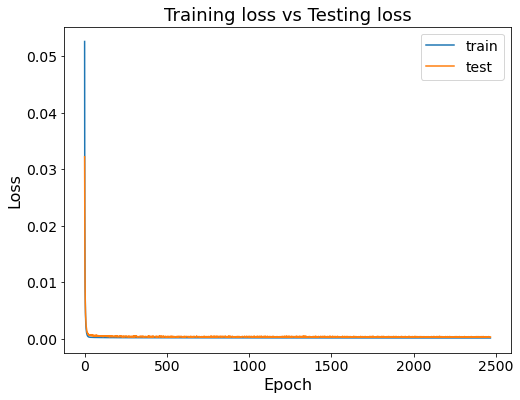

In [39]:
lr = 0.00001
EPOCHS = 6000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)

model_cnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/cnn_shift_s{}_k{}_4layer_sc.h5'.format(S, K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = model_cnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [34]:
# model_cnn.save('saved_model/cnn_shift_s{}_k{}.h5'.format(S, K))

In [45]:
# model_load.predict(test_input).shape

### Performance

In [40]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/cnn_shift_s{}_k{}_4layer_sc.h5'.format(S, K))

In [41]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)


In [42]:
# inv_y

In [43]:
# inv_yhat

In [44]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.056
RMSE = 0.0788
